In [ ]:
# Install dependencies
!pip install transformers torch conllu


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 37.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 27.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 19.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 56.2 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [ ]:
from google.colab import files

# Upload the dataset
uploaded = files.upload()
# e.g., filename = 'en_ewt-ud-train.conllu'


Saving en_ewt-ud-train.conllu to en_ewt-ud-train.conllu


In [ ]:
from conllu import parse
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizerFast

# Load dataset
with open('en_ewt-ud-train.conllu', 'r', encoding='utf-8') as f:
    data = f.read()

# Parse dataset
sentences = parse(data)

# Extract token forms, head indices
examples = []
for sentence in sentences:
    tokens = []
    heads = []
    for token in sentence:
        if isinstance(token['id'], int):  # skip multi-word tokens
            tokens.append(token['form'])
            heads.append(token['head'] if token['head'] is not None else 0)
    examples.append({'tokens': tokens, 'heads': heads})

print(f"Total sentences loaded: {len(examples)}")
print("Example:", examples[0])


Total sentences loaded: 12544
Example: {'tokens': ['Al', '-', 'Zaman', ':', 'American', 'forces', 'killed', 'Shaikh', 'Abdullah', 'al', '-', 'Ani', ',', 'the', 'preacher', 'at', 'the', 'mosque', 'in', 'the', 'town', 'of', 'Qaim', ',', 'near', 'the', 'Syrian', 'border', '.'], 'heads': [0, 3, 1, 7, 6, 7, 1, 7, 8, 8, 12, 8, 15, 15, 8, 18, 18, 15, 21, 21, 18, 23, 21, 28, 28, 28, 28, 21, 1]}


In [ ]:
tokenizer = BertTokenizerFast.from_pretrained('bert-base-cased')
MAX_LEN = 128  # Adjust if needed

class DependencyDataset(Dataset):
    def __init__(self, examples, tokenizer, max_len):
        self.examples = examples
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.examples)

    def __getitem__(self, idx):
        tokens = self.examples[idx]['tokens']
        heads = self.examples[idx]['heads']

        # Tokenize preserving word boundaries
        encoding = self.tokenizer(tokens, is_split_into_words=True, padding='max_length',
                                  truncation=True, max_length=self.max_len, return_tensors='pt')
        input_ids = encoding['input_ids'].squeeze(0)
        attention_mask = encoding['attention_mask'].squeeze(0)
        word_ids = encoding.word_ids(batch_index=0)

        # Align heads
        aligned_heads = []
        for word_idx in word_ids:
            if word_idx is None:
                aligned_heads.append(-100)  # ignore [CLS], [SEP], [PAD]
            else:
                aligned_heads.append(heads[word_idx])

        # Pad aligned_heads to MAX_LEN
        aligned_heads += [-100] * (self.max_len - len(aligned_heads))

        return {'input_ids': input_ids,
                'attention_mask': attention_mask,
                'heads': torch.tensor(aligned_heads[:self.max_len])}

dataset = DependencyDataset(examples, tokenizer, MAX_LEN)
dataloader = DataLoader(dataset, batch_size=8, shuffle=True)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
import torch.nn as nn
from transformers import BertModel

class DependencyParser(nn.Module):
    def __init__(self, hidden_size=768, lstm_hidden=256):
        super(DependencyParser, self).__init__()
        self.bert = BertModel.from_pretrained('bert-base-cased')
        self.bilstm = nn.LSTM(input_size=hidden_size, hidden_size=lstm_hidden,
                              num_layers=1, bidirectional=True, batch_first=True)
        self.head_pred = nn.Linear(lstm_hidden * 2, 1)  # regression output

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        bert_embeddings = outputs.last_hidden_state  # shape: (batch, seq_len, 768)
        lstm_out, _ = self.bilstm(bert_embeddings)  # (batch, seq_len, 512)
        head_preds = self.head_pred(lstm_out).squeeze(-1)  # (batch, seq_len)
        return head_preds


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = DependencyParser().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=2e-5)
loss_fn = nn.MSELoss()

EPOCHS = 10

for epoch in range(EPOCHS):
    model.train()
    total_loss = 0
    for batch in dataloader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        heads = batch['heads'].to(device).float()

        optimizer.zero_grad()
        preds = model(input_ids, attention_mask)

        # Compute loss only on valid tokens (ignore -100)
        mask = (heads != -100)
        loss = loss_fn(preds[mask], heads[mask])

        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(dataloader)
    print(f"Epoch {epoch+1}/{EPOCHS} - Loss: {avg_loss:.4f}")


Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

Epoch 1/10 - Loss: 63.6308
Epoch 2/10 - Loss: 28.4446
Epoch 3/10 - Loss: 17.2392
Epoch 4/10 - Loss: 11.9206
Epoch 5/10 - Loss: 8.6667
Epoch 6/10 - Loss: 6.8540
Epoch 7/10 - Loss: 5.5317
Epoch 8/10 - Loss: 4.1874
Epoch 9/10 - Loss: 3.7891
Epoch 10/10 - Loss: 2.9845


In [ ]:
model.eval()
sample_sentence = examples[0]['tokens']
encoding = tokenizer(sample_sentence, is_split_into_words=True, padding='max_length',
                     truncation=True, max_length=MAX_LEN, return_tensors='pt').to(device)

with torch.no_grad():
    preds = model(encoding['input_ids'], encoding['attention_mask'])
    preds = preds.squeeze(0).cpu().numpy()

# Print tokens with predicted heads
print("\nTokens & Predicted Heads:")
for idx, token in enumerate(sample_sentence):
    print(f"{token:15s} -> {int(preds[idx])}")



Tokens & Predicted Heads:
Al              -> 6
-               -> 0
Zaman           -> 2
:               -> 0
American        -> 1
forces          -> 6
killed          -> 5
Shaikh          -> 6
Abdullah        -> 1
al              -> 6
-               -> 6
Ani             -> 6
,               -> 7
the             -> 9
preacher        -> 10
at              -> 8
the             -> 8
mosque          -> 14
in              -> 14
the             -> 8
town            -> 17
of              -> 17
Qaim            -> 13
,               -> 20
near            -> 19
the             -> 16
Syrian          -> 22
border          -> 20
.               -> 20


In [ ]:
# Example sentence to test
test_sentence = ["I", "love", "deep", "learning", "models"]

# Tokenize and prepare
encoding = tokenizer(test_sentence, is_split_into_words=True,
                     padding='max_length', truncation=True, max_length=MAX_LEN,
                     return_tensors='pt').to(device)

# Predict
model.eval()
with torch.no_grad():
    preds = model(encoding['input_ids'], encoding['attention_mask'])
    preds = preds.squeeze(0).cpu().numpy()  # (seq_len,)

# Align back to original tokens (skip special tokens)
word_ids = encoding.word_ids(batch_index=0)
aligned_preds = []
for idx, word_idx in enumerate(word_ids):
    if word_idx is not None:
        aligned_preds.append((test_sentence[word_idx], int(round(preds[idx]))))

# Print predicted heads
print("\nDependency Predictions:")
for token, head in aligned_preds:
    print(f"{token:15s} -> {head}")



Dependency Predictions:
I               -> 2
love            -> 0
deep            -> 4
learning        -> 5
models          -> 2


In [ ]:
print("\nPredicted Dependency Tree:")
for idx, (token, head) in enumerate(aligned_preds, start=1):
    print(f"Token: {token:10s} (Index: {idx}) -> Head Index: {head}")



Predicted Dependency Tree:
Token: I          (Index: 1) -> Head Index: 2
Token: love       (Index: 2) -> Head Index: 0
Token: deep       (Index: 3) -> Head Index: 4
Token: learning   (Index: 4) -> Head Index: 5
Token: models     (Index: 5) -> Head Index: 2


In [ ]:
def evaluate_accuracy(model, dataloader):
    model.eval()
    total_tokens = 0
    correct_preds = 0

    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            true_heads = batch['heads'].to(device)

            preds = model(input_ids, attention_mask)
            preds_rounded = torch.round(preds).long()

            mask = (true_heads != -100)
            correct = (preds_rounded[mask] == true_heads[mask]).sum().item()
            total = mask.sum().item()

            correct_preds += correct
            total_tokens += total

    accuracy = correct_preds / total_tokens
    return accuracy

# Example usage
acc = evaluate_accuracy(model, dataloader)
print(f"Accuracy: {acc * 100:.2f}%")


Accuracy: 66.79%


In [ ]:
# Example normal sentence
test_sentence = "I love deep learning models."

# Tokenize the sentence directly
encoding = tokenizer(test_sentence,
                     padding='max_length', truncation=True, max_length=MAX_LEN,
                     return_tensors='pt').to(device)

# Predict
model.eval()
with torch.no_grad():
    preds = model(encoding['input_ids'], encoding['attention_mask'])
    preds = preds.squeeze(0).cpu().numpy()  # (seq_len,)

# Align predictions to actual tokens
tokens = tokenizer.convert_ids_to_tokens(encoding['input_ids'].squeeze().cpu())
aligned_preds = []
for idx, token in enumerate(tokens):
    if token not in ['[PAD]', '[CLS]', '[SEP]']:
        aligned_preds.append((token, int(round(preds[idx]))))

# Print predictions
print("\nDependency Predictions:")
for token, head in aligned_preds:
    print(f"{token:15s} -> {head}")



Dependency Predictions:
I               -> 2
love            -> 0
deep            -> 4
learning        -> 5
models          -> 2
.               -> 2


In [ ]:
print("\nPredicted Dependency Tree:")
for idx, (token, head) in enumerate(aligned_preds, start=1):
    print(f"Token: {token:10s} (Index: {idx}) -> Head Index: {head}")



Predicted Dependency Tree:
Token: I          (Index: 1) -> Head Index: 2
Token: love       (Index: 2) -> Head Index: 0
Token: deep       (Index: 3) -> Head Index: 4
Token: learning   (Index: 4) -> Head Index: 5
Token: models     (Index: 5) -> Head Index: 2
Token: .          (Index: 6) -> Head Index: 2


In [ ]:

# Example normal sentence
test_sentence = "Artificial intelligence is transforming industries and creating new opportunities for innovation."

# Tokenize the sentence directly
encoding = tokenizer(test_sentence,
                     padding='max_length', truncation=True, max_length=MAX_LEN,
                     return_tensors='pt').to(device)

# Predict
model.eval()
with torch.no_grad():
    preds = model(encoding['input_ids'], encoding['attention_mask'])
    preds = preds.squeeze(0).cpu().numpy()  # (seq_len,)

# Align predictions to actual tokens
tokens = tokenizer.convert_ids_to_tokens(encoding['input_ids'].squeeze().cpu())
aligned_preds = []
for idx, token in enumerate(tokens):
    if token not in ['[PAD]', '[CLS]', '[SEP]']:
        aligned_preds.append((token, int(round(preds[idx]))))

# Print predictions
print("\nDependency Predictions:")
for token, head in aligned_preds:
    print(f"{token:15s} -> {head}")



Dependency Predictions:
Art             -> 2
##ific          -> 2
##ial           -> 2
intelligence    -> 4
is              -> 4
transforming    -> 0
industries      -> 4
and             -> 7
creating        -> 4
new             -> 9
opportunities   -> 7
for             -> 11
innovation      -> 9
.               -> 4


In [ ]:
print("\nPredicted Dependency Tree:")
for idx, (token, head) in enumerate(aligned_preds, start=1):
    print(f"Token: {token:10s} (Index: {idx}) -> Head Index: {head}")



Predicted Dependency Tree:
Token: Art        (Index: 1) -> Head Index: 2
Token: ##ific     (Index: 2) -> Head Index: 2
Token: ##ial      (Index: 3) -> Head Index: 2
Token: intelligence (Index: 4) -> Head Index: 4
Token: is         (Index: 5) -> Head Index: 4
Token: transforming (Index: 6) -> Head Index: 0
Token: industries (Index: 7) -> Head Index: 4
Token: and        (Index: 8) -> Head Index: 7
Token: creating   (Index: 9) -> Head Index: 4
Token: new        (Index: 10) -> Head Index: 9
Token: opportunities (Index: 11) -> Head Index: 7
Token: for        (Index: 12) -> Head Index: 11
Token: innovation (Index: 13) -> Head Index: 9
Token: .          (Index: 14) -> Head Index: 4


In [ ]:
test_sentences = [
    "The cat sat on the mat.",
    "He reads books daily.",
    "She loves chocolate.",
    "Artificial intelligence is transforming industries and creating new opportunities for innovation.",
    "Although he was tired, he completed the assignment before the deadline."
]

for test_sentence in test_sentences:
    encoding = tokenizer(test_sentence, padding='max_length', truncation=True,
                         max_length=MAX_LEN, return_tensors='pt').to(device)

    model.eval()
    with torch.no_grad():
        preds = model(encoding['input_ids'], encoding['attention_mask'])
        preds = preds.squeeze(0).cpu().numpy()

    tokens = tokenizer.convert_ids_to_tokens(encoding['input_ids'].squeeze().cpu())
    aligned_preds = []
    for idx, token in enumerate(tokens):
        if token not in ['[PAD]', '[CLS]', '[SEP]']:
            aligned_preds.append((token, int(round(preds[idx]))))

    print(f"\nSentence: {test_sentence}")
    print("Dependency Predictions:")
    for token, head in aligned_preds:
        print(f"{token:15s} -> {head}")



Sentence: The cat sat on the mat.
Dependency Predictions:
The             -> 2
cat             -> 3
sat             -> 0
on              -> 6
the             -> 6
mat             -> 3
.               -> 3

Sentence: He reads books daily.
Dependency Predictions:
He              -> 2
reads           -> 0
books           -> 2
daily           -> 2
.               -> 2

Sentence: She loves chocolate.
Dependency Predictions:
She             -> 2
loves           -> 0
chocolate       -> 2
.               -> 2

Sentence: Artificial intelligence is transforming industries and creating new opportunities for innovation.
Dependency Predictions:
Art             -> 2
##ific          -> 2
##ial           -> 2
intelligence    -> 4
is              -> 4
transforming    -> 0
industries      -> 4
and             -> 7
creating        -> 4
new             -> 9
opportunities   -> 7
for             -> 11
innovation      -> 9
.               -> 4

Sentence: Although he was tired, he completed the assignment be

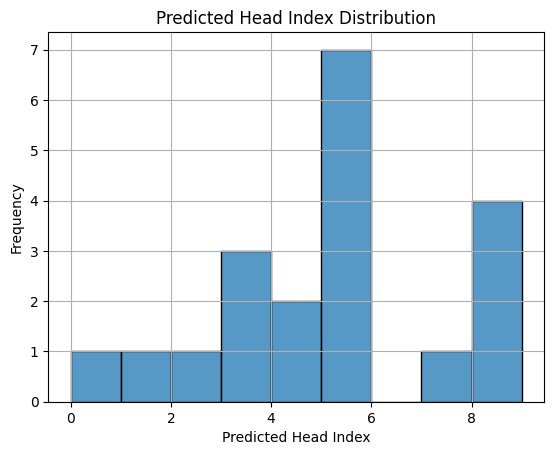

In [ ]:
# Example usage of plot_head_distribution
import numpy as np

# Let's assume you have predictions from your test example
# Replace this with your actual predictions
dummy_preds = np.random.randint(0, 10, size=(1, 20))

plot_head_distribution(dummy_preds)


In [ ]:
pip install networkx matplotlib


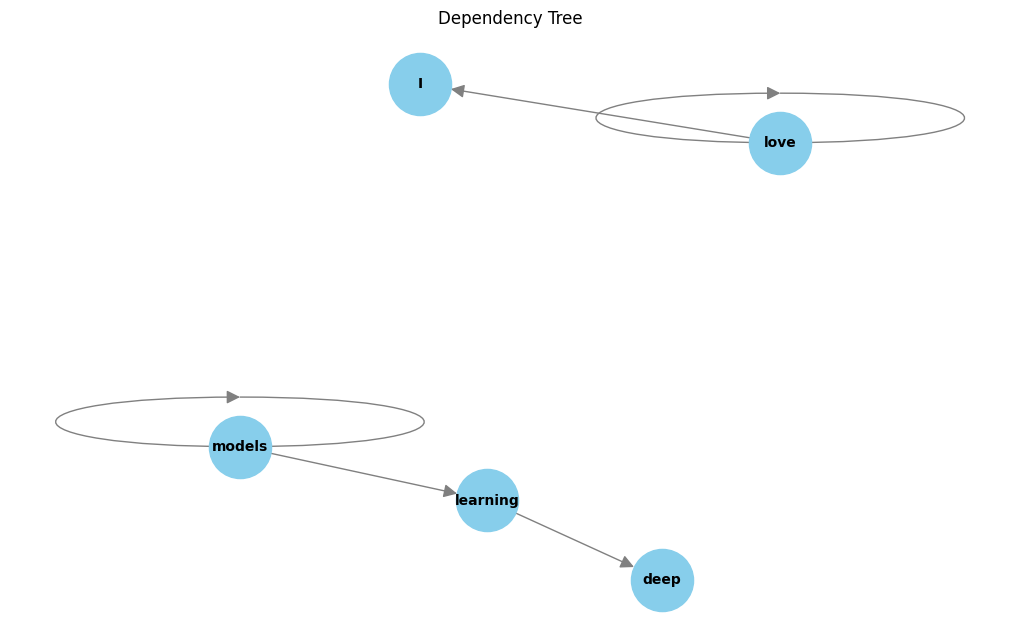

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt

def plot_dependency_tree(sentence_tokens, predicted_heads):
    """
    Plots a dependency tree using networkx and matplotlib.

    :param sentence_tokens: list of token strings
    :param predicted_heads: list of predicted head indices
    """
    G = nx.DiGraph()

    # Add nodes
    for i, token in enumerate(sentence_tokens):
        G.add_node(i, label=token)

    # Add edges based on predicted heads
    for i, head_idx in enumerate(predicted_heads):
        if head_idx >= 0 and head_idx < len(sentence_tokens):  # skip invalid heads
            G.add_edge(head_idx, i)

    # Layout
    pos = nx.spring_layout(G, seed=42)

    plt.figure(figsize=(10, 6))
    nx.draw(G, pos, with_labels=True, labels=nx.get_node_attributes(G, 'label'),
            node_color='skyblue', node_size=2000, font_size=10, arrowsize=20,
            edge_color='gray', font_weight='bold')
    plt.title("Dependency Tree")
    plt.show()

# Example usage:
# Suppose you have:
sentence_tokens = ["I", "love", "deep", "learning", "models"]
predicted_heads = [1, 1, 3, 4, 4]  # Example predicted heads

plot_dependency_tree(sentence_tokens, predicted_heads)


In [ ]:
pip install spacy


In [ ]:
import spacy
from spacy.tokens import Doc
from spacy import displacy

# Load a blank English pipeline
nlp = spacy.blank("en")

def visualize_dependency_tree(sentence_tokens, predicted_heads):
    """
    Visualizes dependency tree using spacy's displacy.
    """
    words = sentence_tokens
    heads = predicted_heads

    # Create spacy Doc object manually
    doc = Doc(nlp.vocab, words=words)

    # Create dependency parse data
    # Each token's head offset
    heads_offsets = [h - i for i, h in enumerate(heads)]

    for token, head_offset in zip(doc, heads_offsets):
        token.head = doc[token.i + head_offset] if 0 <= token.i + head_offset < len(doc) else token
        token.dep_ = "dep"  # just a placeholder

    # Visualize
    displacy.render(doc, style="dep", jupyter=True, options={"compact": True, "distance": 100})

# Example usage:
sentence_tokens = ["I", "love", "deep", "learning", "models"]
predicted_heads = [1, 1, 3, 4, 4]  # Replace with your predicted heads

visualize_dependency_tree(sentence_tokens, predicted_heads)


In [ ]:
sentence = "Although the project was challenging, the team managed to complete it successfully within the deadline."

# Tokenize
encoding = tokenizer(sentence, padding='max_length', truncation=True, max_length=MAX_LEN,
                     return_tensors='pt').to(device)

# Predict
model.eval()
with torch.no_grad():
    preds = model(encoding['input_ids'], encoding['attention_mask'])
    preds = preds.squeeze(0).cpu().numpy()

# Get word IDs to align predictions
word_ids = encoding.word_ids(batch_index=0)

# Extract words and predicted heads
tokens = tokenizer.convert_ids_to_tokens(encoding['input_ids'][0])
aligned_preds = []
for idx, word_idx in enumerate(word_ids):
    if word_idx is not None:
        aligned_preds.append((tokens[idx], int(round(preds[idx]))))

# Print predicted heads
print("\nDependency Predictions:")
for token, head in aligned_preds:
    print(f"{token:15s} -> {head}")



Dependency Predictions:
Although        -> 4
the             -> 3
project         -> 4
was             -> 5
challenging     -> 9
,               -> 5
the             -> 8
team            -> 9
managed         -> 0
to              -> 11
complete        -> 9
it              -> 11
successfully    -> 11
within          -> 16
the             -> 16
deadline        -> 10
.               -> 9


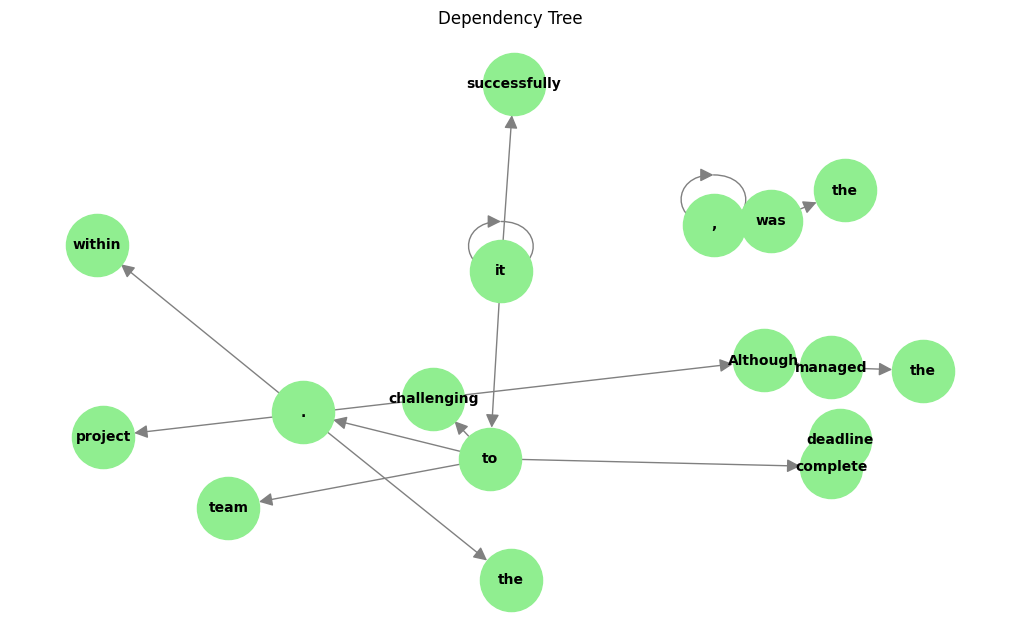

In [ ]:
import torch
import networkx as nx
import matplotlib.pyplot as plt

def plot_dependency_tree_for_sentence(sentence, model, tokenizer, device, MAX_LEN=128):
    """
    Tokenizes the sentence, predicts heads using the model, and plots the dependency tree.

    :param sentence: string
    :param model: trained DependencyParser
    :param tokenizer: BERT tokenizer
    :param device: cuda or cpu
    :param MAX_LEN: maximum sequence length
    """
    # Tokenize the sentence as a whole
    encoding = tokenizer(sentence, padding='max_length', truncation=True, max_length=MAX_LEN,
                         return_tensors='pt').to(device)

    # Predict heads
    model.eval()
    with torch.no_grad():
        preds = model(encoding['input_ids'], encoding['attention_mask'])
        preds = preds.squeeze(0).cpu().numpy()  # shape: (seq_len,)

    # Align back to tokens (ignore special tokens)
    word_ids = encoding.word_ids(batch_index=0)
    aligned_preds = []
    aligned_tokens = []
    for idx, word_idx in enumerate(word_ids):
        if word_idx is not None:
            token = tokenizer.convert_ids_to_tokens(int(encoding['input_ids'][0][idx]))
            aligned_tokens.append(token)
            aligned_preds.append(int(round(preds[idx])))

    # Plotting
    G = nx.DiGraph()
    for i, token in enumerate(aligned_tokens):
        G.add_node(i, label=token)
    for i, head_idx in enumerate(aligned_preds):
        if head_idx >= 0 and head_idx < len(aligned_tokens):  # skip invalid
            G.add_edge(head_idx, i)
    pos = nx.spring_layout(G, seed=42)
    plt.figure(figsize=(10, 6))
    nx.draw(G, pos, with_labels=True, labels=nx.get_node_attributes(G, 'label'),
            node_color='lightgreen', node_size=2000, font_size=10, arrowsize=20,
            edge_color='gray', font_weight='bold')
    plt.title("Dependency Tree")
    plt.show()

# Example usage:
sentence = "Although the project was challenging, the team managed to complete it successfully within the deadline."
plot_dependency_tree_for_sentence(sentence, model, tokenizer, device, MAX_LEN=64)


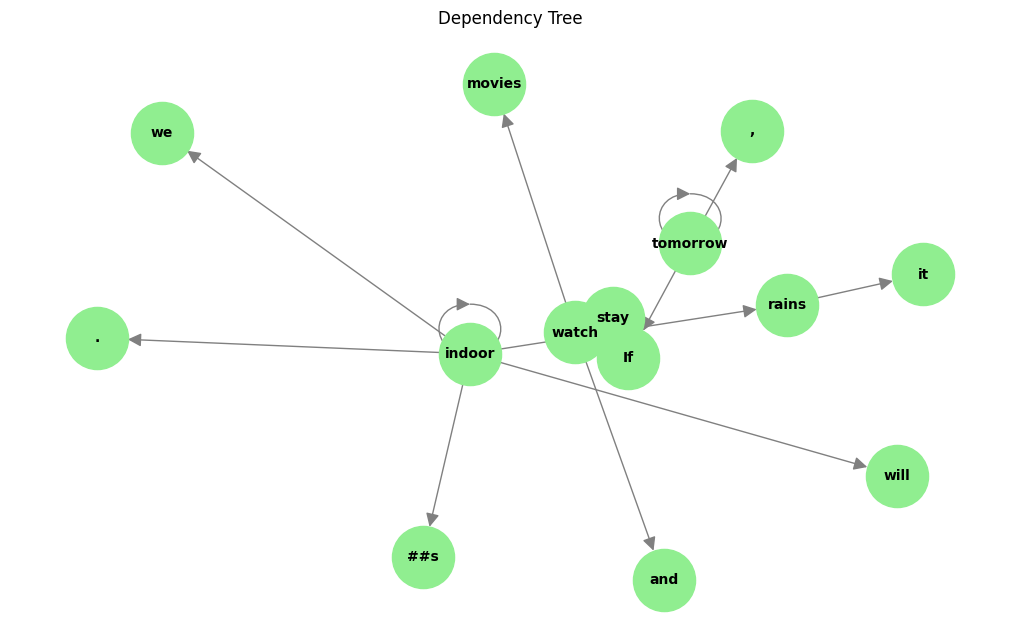

In [ ]:
import torch
import networkx as nx
import matplotlib.pyplot as plt

def plot_dependency_tree_for_sentence(sentence, model, tokenizer, device, MAX_LEN=128):
    """
    Tokenizes the sentence, predicts heads using the model, and plots the dependency tree.

    :param sentence: string
    :param model: trained DependencyParser
    :param tokenizer: BERT tokenizer
    :param device: cuda or cpu
    :param MAX_LEN: maximum sequence length
    """
    # Tokenize the sentence as a whole
    encoding = tokenizer(sentence, padding='max_length', truncation=True, max_length=MAX_LEN,
                         return_tensors='pt').to(device)

    # Predict heads
    model.eval()
    with torch.no_grad():
        preds = model(encoding['input_ids'], encoding['attention_mask'])
        preds = preds.squeeze(0).cpu().numpy()  # shape: (seq_len,)

    # Align back to tokens (ignore special tokens)
    word_ids = encoding.word_ids(batch_index=0)
    aligned_preds = []
    aligned_tokens = []
    for idx, word_idx in enumerate(word_ids):
        if word_idx is not None:
            token = tokenizer.convert_ids_to_tokens(int(encoding['input_ids'][0][idx]))
            aligned_tokens.append(token)
            aligned_preds.append(int(round(preds[idx])))

    # Plotting
    G = nx.DiGraph()
    for i, token in enumerate(aligned_tokens):
        G.add_node(i, label=token)
    for i, head_idx in enumerate(aligned_preds):
        if head_idx >= 0 and head_idx < len(aligned_tokens):  # skip invalid
            G.add_edge(head_idx, i)
    pos = nx.spring_layout(G, seed=42)
    plt.figure(figsize=(10, 6))
    nx.draw(G, pos, with_labels=True, labels=nx.get_node_attributes(G, 'label'),
            node_color='lightgreen', node_size=2000, font_size=10, arrowsize=20,
            edge_color='gray', font_weight='bold')
    plt.title("Dependency Tree")
    plt.show()

# Example usage:
sentence = "If it rains tomorrow, we will stay indoors and watch movies."
plot_dependency_tree_for_sentence(sentence, model, tokenizer, device, MAX_LEN=64)


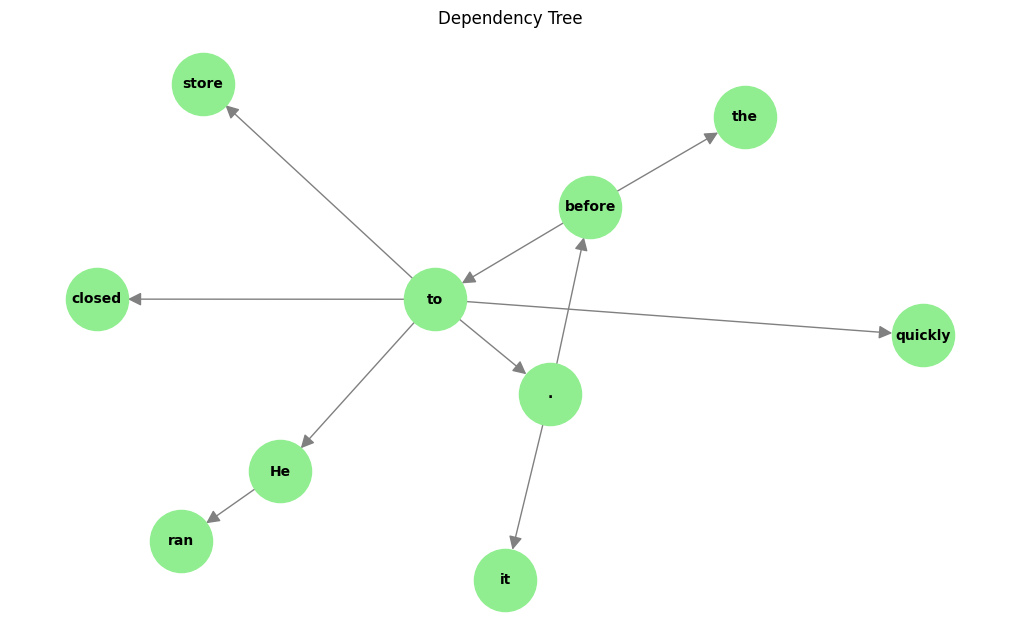

In [ ]:
import torch
import networkx as nx
import matplotlib.pyplot as plt

def plot_dependency_tree_for_sentence(sentence, model, tokenizer, device, MAX_LEN=128):
    """
    Tokenizes the sentence, predicts heads using the model, and plots the dependency tree.

    :param sentence: string
    :param model: trained DependencyParser
    :param tokenizer: BERT tokenizer
    :param device: cuda or cpu
    :param MAX_LEN: maximum sequence length
    """
    # Tokenize the sentence as a whole
    encoding = tokenizer(sentence, padding='max_length', truncation=True, max_length=MAX_LEN,
                         return_tensors='pt').to(device)

    # Predict heads
    model.eval()
    with torch.no_grad():
        preds = model(encoding['input_ids'], encoding['attention_mask'])
        preds = preds.squeeze(0).cpu().numpy()  # shape: (seq_len,)

    # Align back to tokens (ignore special tokens)
    word_ids = encoding.word_ids(batch_index=0)
    aligned_preds = []
    aligned_tokens = []
    for idx, word_idx in enumerate(word_ids):
        if word_idx is not None:
            token = tokenizer.convert_ids_to_tokens(int(encoding['input_ids'][0][idx]))
            aligned_tokens.append(token)
            aligned_preds.append(int(round(preds[idx])))

    # Plotting
    G = nx.DiGraph()
    for i, token in enumerate(aligned_tokens):
        G.add_node(i, label=token)
    for i, head_idx in enumerate(aligned_preds):
        if head_idx >= 0 and head_idx < len(aligned_tokens):  # skip invalid
            G.add_edge(head_idx, i)
    pos = nx.spring_layout(G, seed=42)
    plt.figure(figsize=(10, 6))
    nx.draw(G, pos, with_labels=True, labels=nx.get_node_attributes(G, 'label'),
            node_color='lightgreen', node_size=2000, font_size=10, arrowsize=20,
            edge_color='gray', font_weight='bold')
    plt.title("Dependency Tree")
    plt.show()

# Example usage:
sentence = "He quickly ran to the store before it closed."
plot_dependency_tree_for_sentence(sentence, model, tokenizer, device, MAX_LEN=64)


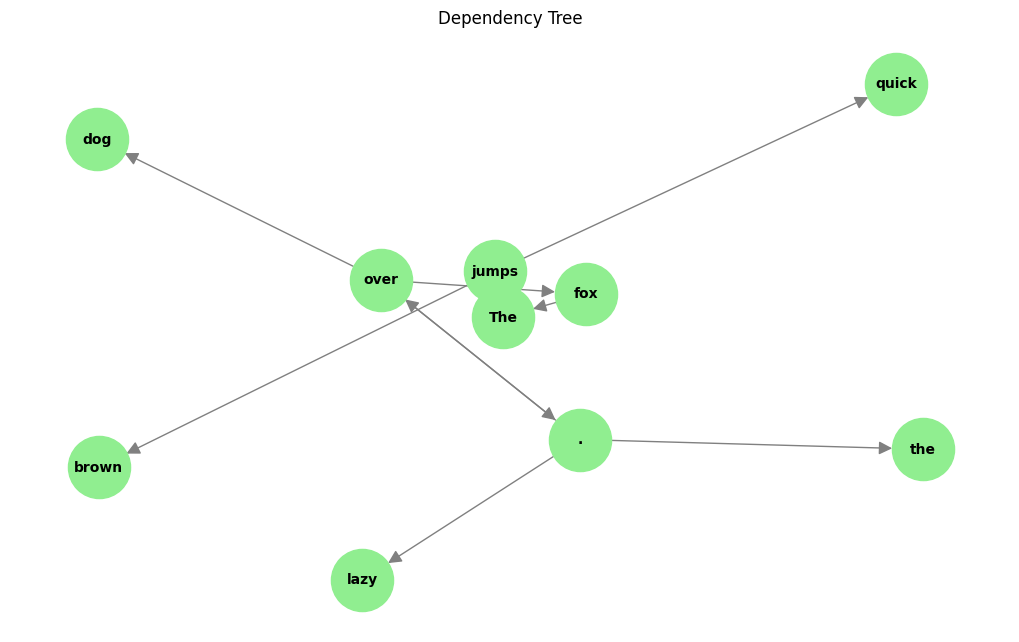

In [ ]:
import torch
import networkx as nx
import matplotlib.pyplot as plt

def plot_dependency_tree_for_sentence(sentence, model, tokenizer, device, MAX_LEN=128):
    """
    Tokenizes the sentence, predicts heads using the model, and plots the dependency tree.

    :param sentence: string
    :param model: trained DependencyParser
    :param tokenizer: BERT tokenizer
    :param device: cuda or cpu
    :param MAX_LEN: maximum sequence length
    """
    # Tokenize the sentence as a whole
    encoding = tokenizer(sentence, padding='max_length', truncation=True, max_length=MAX_LEN,
                         return_tensors='pt').to(device)

    # Predict heads
    model.eval()
    with torch.no_grad():
        preds = model(encoding['input_ids'], encoding['attention_mask'])
        preds = preds.squeeze(0).cpu().numpy()  # shape: (seq_len,)

    # Align back to tokens (ignore special tokens)
    word_ids = encoding.word_ids(batch_index=0)
    aligned_preds = []
    aligned_tokens = []
    for idx, word_idx in enumerate(word_ids):
        if word_idx is not None:
            token = tokenizer.convert_ids_to_tokens(int(encoding['input_ids'][0][idx]))
            aligned_tokens.append(token)
            aligned_preds.append(int(round(preds[idx])))

    # Plotting
    G = nx.DiGraph()
    for i, token in enumerate(aligned_tokens):
        G.add_node(i, label=token)
    for i, head_idx in enumerate(aligned_preds):
        if head_idx >= 0 and head_idx < len(aligned_tokens):  # skip invalid
            G.add_edge(head_idx, i)
    pos = nx.spring_layout(G, seed=42)
    plt.figure(figsize=(10, 6))
    nx.draw(G, pos, with_labels=True, labels=nx.get_node_attributes(G, 'label'),
            node_color='lightgreen', node_size=2000, font_size=10, arrowsize=20,
            edge_color='gray', font_weight='bold')
    plt.title("Dependency Tree")
    plt.show()

# Example usage:
sentence = "The quick brown fox jumps over the lazy dog."
plot_dependency_tree_for_sentence(sentence, model, tokenizer, device, MAX_LEN=64)


In [ ]:
import spacy
from spacy.tokens import Doc
from spacy import displacy

# Load a blank English pipeline
nlp = spacy.blank("en")

def visualize_dependency_tree(sentence_tokens, predicted_heads):
    """
    Visualizes dependency tree using spacy's displacy.
    """
    words = sentence_tokens
    heads = predicted_heads

    # Create spacy Doc object manually
    doc = Doc(nlp.vocab, words=words)

    # Create dependency parse data
    # Each token's head offset
    heads_offsets = [h - i for i, h in enumerate(heads)]

    for token, head_offset in zip(doc, heads_offsets):
        token.head = doc[token.i + head_offset] if 0 <= token.i + head_offset < len(doc) else token
        token.dep_ = "dep"  # just a placeholder

    # Visualize
    displacy.render(doc, style="dep", jupyter=True, options={"compact": True, "distance": 100})

# Example usage:
sentence_tokens = ["He", "quickly", "ran", "to", "the", "store", "before", "it", "closed]
predicted_heads = [1, 1, 3, 4, 4]  # Replace with your predicted heads

visualize_dependency_tree(sentence_tokens, predicted_heads)


In [ ]:
loss_history = []

for epoch in range(EPOCHS):
    model.train()
    total_loss = 0
    for batch in dataloader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        heads = batch['heads'].to(device).float()

        optimizer.zero_grad()
        preds = model(input_ids, attention_mask)

        # Compute loss only on valid tokens (ignore -100)
        mask = (heads != -100)
        loss = loss_fn(preds[mask], heads[mask])

        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(dataloader)
    loss_history.append(avg_loss)  # Save loss
    print(f"Epoch {epoch+1}/{EPOCHS} - Loss: {avg_loss:.4f}")


Epoch 1/10 - Loss: 2.6794
Epoch 2/10 - Loss: 2.3839
Epoch 3/10 - Loss: 2.1791
Epoch 4/10 - Loss: 1.9470
Epoch 5/10 - Loss: 1.7510
Epoch 6/10 - Loss: 1.6011
Epoch 7/10 - Loss: 1.5045
Epoch 8/10 - Loss: 1.2550
Epoch 9/10 - Loss: 1.1649
Epoch 10/10 - Loss: 1.2088


In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 4))
plt.plot(range(1, EPOCHS+1), loss_history, marker='o', color='blue')
plt.xlabel("Epoch")
plt.ylabel("Mean Squared Error Loss")
plt.title("Training Loss Over Epochs")
plt.grid()
plt.show()


In [ ]:
plt.figure(figsize=(6, 6))
plt.scatter(all_true, all_preds, alpha=0.3, color='green')
plt.xlabel("True Head Index")
plt.ylabel("Predicted Head Index")
plt.title("Predicted vs. True Head Indices")
plt.grid()
plt.show()
